### MRMR-More

More experiments with the MRMR codebase.

In [1]:
import sys
sys.path.append("../..")
from exp_run_config import Config
Config.PROJECTNAME = "WaterBerryFarms"

import pathlib
import yaml
import tqdm
from wbf_simulate import run_nrobot1day
from mrmr_graphics import load_back_results, show_robot_with_plan, show_robot_trajectories_and_detections, count_detections, show_agentwise_detections, show_comparative_detections

In [2]:
# Run an experiment with a different budget
experiment_path = pathlib.Path(Config()["experiment_external"])
experiment_path.mkdir(exist_ok=True)
experiment_data = pathlib.Path(Config()["data_external"])
experiment_data.mkdir(exist_ok=True)

Config().set_experiment_path(experiment_path)
Config().set_experiment_data(experiment_data)
# FIXME this is dangerous, because if it has the original paths, it overwrites the experiments, this needs to be fixed
Config().copy_experiment("mrmr")
Config().copy_experiment("environment")
Config().copy_experiment("policy")
Config().copy_experiment("estimator")
Config().copy_experiment("score")

exp_dest = Config().get_experiment("mrmr", "mrmr_more")

ROBOT_COLORS = ["#E69F00", "#56B4E9", "#009E73", "#00FFFF", "#FF00FF",  "#FFFF00"]
SHORT_NAME_LOOKUP = {}

***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\WaterBerryFarms\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\WaterBerryFarms\settings\WBF-config-LotziYoga.yaml
***ExpRun**: Experiment config path changed to c:\Users\lboloni\Documents\Code\_TempData\WBF-exp-external
***ExpRun**: Experiment data path changed to c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external
***ExpRun**: Experiment mrmr copied to c:\Users\lboloni\Documents\Code\_TempData\WBF-exp-external\mrmr
***ExpRun**: Experiment environment copied to c:\Users\lboloni\Documents\Code\_TempData\WBF-exp-external\environment
***ExpRun**: Experiment policy copied to c:\Users\lboloni\Documents\Code\_TempData\WBF-exp-external\policy
***ExpRun**: Experiment estimator copied to c:\Users\lboloni\Documents\Code\_TempData\WBF-exp-external\estimator
***ExpRun**: Experiment score copied to c:\Users\lboloni\Documents\Code\_TempData\WBF-exp-external\s

In [3]:
def generate_rw(experiment="mrmr", n_robots = 1, budget = 1000, environment = "mrmr-custom-notclustered"):
    """Generate experiment with n robots following random waypoint, and save it to the experiment path"""
    runname = f"gen-rw-n_{n_robots}-b_{budget}-e_{environment}"
    val = {}    
    val["name"] = "n random waypoint"

    val["exp_environment"] = "environment"
    val["run_environment"] = environment

    val["exp_estimator"] = "estimator"
    val["run_estimator"] = "adaptive-disk"

    val["exp_score"] = "score"
    val["run_score"] = "weighted_asymmetric"

    val["timesteps-per-day"] = budget
    val["time-start-environment"] = 19

    robots = []
    val["robots"] = robots

    for robot in range(n_robots):
        v = {}
        robots.append(v)
        v["name"] = f"robot-{robot+1}"
        v["exp-policy"] = "policy"
        v["run-policy"] = "random-waypoint"
        vextra = {}
        v["exp-policy-extra-parameters"] = vextra
        vextra["seed"] = robot
        vextra["policy-name"] = f"rwp-{robot}"
        vextra["budget"] = budget
    # save the generated exprun spec
    path = pathlib.Path(Config().get_experiment_path(), experiment, runname + ".yaml")
    with open(path, "w") as f:
        yaml.dump(val, f)
    return runname

In [4]:
def generate_lawnmowers(experiment = "mrmr", n_robots = 1, budget = 1000, environment = "mrmr-custom-notclustered"):
    """Generate experiment with n robots following lawnmower, with the area being divided into n areas"""
    runname = f"gen-lawn-n_{n_robots}-b_{budget}-e_{environment}"
    val = {}    
    val["name"] = "n random waypoint"

    val["exp_environment"] = "environment"
    val["run_environment"] = environment

    val["exp_estimator"] = "estimator"
    val["run_estimator"] = "adaptive-disk"

    val["exp_score"] = "score"
    val["run_score"] = "weighted_asymmetric"

    val["timesteps-per-day"] = budget
    val["time-start-environment"] = 19

    robots = []
    val["robots"] = robots

    for robot in range(n_robots):
        v = {}
        robots.append(v)
        v["name"] = f"robot-{robot+1}"
        v["exp-policy"] = "policy"
        v["run-policy"] = "fixed-budget-lawnmower"
        vextra = {}
        v["exp-policy-extra-parameters"] = vextra
        area = [0,0,0,0]
        border = 5
        width = (100 - 2 * border) / n_robots
        area[0] = int(border)
        area[1] = int(border + robot * width)
        area[2] = 100 - border
        area[3] = int(border + (robot+1) * width)
        vextra["area"] = str(area)
        vextra["policy-name"] = f"lawn-{robot}"
        vextra["budget"] = budget

    # save the generated path 
    path = pathlib.Path(Config().get_experiment_path(), experiment, runname + ".yaml")
    with open(path, "w") as f:
        yaml.dump(val, f)
    return runname

In [5]:
def generate_mrmr(experiment="mrmr", n_robots = 1, budget = 1000, environment = "mrmr-custom-notclustered"):
    """Generate experiment with n robots following lawnmower, with the area being divided into n areas"""
    runname = f"gen-mrmr-n_{n_robots}-b_{budget}-e_{environment}"
    val = {}    
    val["name"] = "n random waypoint"

    val["exp_environment"] = "environment"
    val["run_environment"] = environment

    val["exp_estimator"] = "estimator"
    val["run_estimator"] = "adaptive-disk"

    val["exp_score"] = "score"
    val["run_score"] = "weighted_asymmetric"

    val["timesteps-per-day"] = budget
    val["time-start-environment"] = 19

    robots = []
    val["robots"] = robots

    # generate the first robot, the pioneer
    v = {}
    robots.append(v)
    v["name"] = f"pio"
    v["exp-policy"] = "policy"
    v["run-policy"] = "generic"    
    vextra = {}
    v["exp-policy-extra-parameters"] = vextra
    vextra["policy-name"] = f"mrmr-pioneer"
    vextra["policy-code"] = "MRMR_Pioneer"
    vextra["seed"] = 1
    vextra["budget"] = budget

    # generate the other robots, the contractors
    for robot in range(n_robots-1):
        v = {}
        robots.append(v)
        v["name"] = f"con-{robot}"
        v["exp-policy"] = "policy"
        v["run-policy"] = "generic"
        vextra = {}
        v["exp-policy-extra-parameters"] = vextra
        vextra["seed"] = robot + 1
        vextra["policy-name"] = f"mrmr-contractor-{robot}"
        vextra["policy-code"] = "MRMR_Contractor"
        vextra["budget"] = budget

    # save the generated path 
    path = pathlib.Path(Config().get_experiment_path(), experiment, runname + ".yaml")
    with open(path, "w") as f:
        yaml.dump(val, f)
    return runname

### Generate a range of experiments

In [6]:
# run = generate_rw(n_robots=3, budget=1000)
# run = generate_lawnmowers(n_robots=3, budget=1000)
runs = []
# runs for comparison different robots, budget 1000
runs_b1000_clustered = []
runs_n3_clustered = []
runs_b1000_unclustered = []
runs_n3_unclustered = []

# FIXME: generate some other lists as well
experiment = "mrmr"

for n_robots in range(1, 5):
    #for budget in [500, 1000, 1500, 2000]:
    for budget in [500, 1000, 1500]:
        for environment in ["mrmr-custom-notclustered", "mrmr-custom-clustered"]:
            # lawnmowers
            runs2 = []
            run = generate_lawnmowers(experiment, n_robots=n_robots, budget=budget, environment = environment)
            runs2.append(run)
            # random waypoint
            run = generate_rw(experiment, n_robots=n_robots, budget=budget, environment = environment)
            runs2.append(run)
            # mrmr
            run = generate_mrmr(experiment, n_robots=n_robots, budget=budget, environment = environment)
            runs2.append(run)
            # 
            runs.extend(runs2)
            if budget == 1000 and environment == "mrmr-custom-clustered":
                runs_b1000_clustered.extend(runs2)
            if budget == 1000 and environment == "mrmr-custom-notclustered":
                runs_b1000_unclustered.extend(runs2)
            if n_robots == 3 and environment == "mrmr-custom-clustered":
                runs_n3_clustered.extend(runs2)
            if n_robots == 3 and environment == "mrmr-custom-notclustered":
                runs_n3_unclustered.extend(runs2)



### Run the experiments
Run all the experiments

In [7]:
for run in tqdm.tqdm(runs):
    exp = Config().get_experiment("mrmr", run)
    run_nrobot1day(exp)

  0%|          | 0/72 [00:00<?, ?it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-lawn-n_1-b_500-e_mrmr-custom-notclustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-rw-n_1-b_500-e_mrmr-custom-notclustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-mrmr-n_1-b_500-e_mrmr-custom-notclustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-

 28%|██▊       | 20/72 [00:00<00:00, 194.17it/s]

Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-rw-n_2-b_500-e_mrmr-custom-notclustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_500-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-mrmr-n_2-b_500-e_mrmr-custom-notclustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-lawn-n_2-b_500-e_mrmr-custom-clustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-rw-n_2-b_500-e_mrmr-custom-clustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_500-e

 56%|█████▌    | 40/72 [00:00<00:00, 156.30it/s]

Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-lawn-n_3-b_500-e_mrmr-custom-clustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-rw-n_3-b_500-e_mrmr-custom-clustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-mrmr-n_3-b_500-e_mrmr-custom-clustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1000-e

 79%|███████▉  | 57/72 [00:00<00:00, 109.12it/s]

Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-mrmr-n_4-b_500-e_mrmr-custom-notclustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-lawn-n_4-b_500-e_mrmr-custom-clustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-rw-n_4-b_500-e_mrmr-custom-clustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-mrmr-n_4-b_500-e_mrmr-custom-clustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1000-e_mr

 97%|█████████▋| 70/72 [00:00<00:00, 90.09it/s] 

Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-lawn-n_4-b_1500-e_mrmr-custom-clustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1500-e_mrmr-custom-clustered successfully loaded
Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-rw-n_4-b_1500-e_mrmr-custom-clustered\results.pickle
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1500-e_mrmr-custom-clustered successfully loaded


100%|██████████| 72/72 [00:00<00:00, 101.66it/s]

Results file already exists:
c:\Users\lboloni\Documents\Code\_TempData\WBF-data-external\mrmr\gen-mrmr-n_4-b_1500-e_mrmr-custom-clustered\results.pickle


In [8]:
### Load back the experiments in runs
all_results = load_back_results("mrmr", runs)
all_results.keys()

  0%|          | 0/72 [00:00<?, ?it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_500-e_mrmr-custom-notclustered successfully loaded


  4%|▍         | 3/72 [00:00<00:02, 26.54it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_500-e_mrmr-custom-clustered successfully loaded


  8%|▊         | 6/72 [00:00<00:02, 23.47it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_1000-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_1000-e_mrmr-custom-notclustered successfully loaded


 12%|█▎        | 9/72 [00:00<00:03, 17.10it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_1000-e_mrmr-custom-clustered successfully loaded


 15%|█▌        | 11/72 [00:00<00:06,  9.52it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_1000-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_1500-e_mrmr-custom-notclustered successfully loaded


 18%|█▊        | 13/72 [00:01<00:07,  8.35it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_1500-e_mrmr-custom-notclustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_1500-e_mrmr-custom-notclustered successfully loaded


 21%|██        | 15/72 [00:01<00:07,  7.34it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_1-b_1500-e_mrmr-custom-clustered successfully loaded


 22%|██▏       | 16/72 [00:01<00:07,  7.12it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_1-b_1500-e_mrmr-custom-clustered successfully loaded


 24%|██▎       | 17/72 [00:01<00:07,  6.90it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_1-b_1500-e_mrmr-custom-clustered successfully loaded


 25%|██▌       | 18/72 [00:02<00:13,  4.12it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_500-e_mrmr-custom-notclustered successfully loaded


 26%|██▋       | 19/72 [00:02<00:11,  4.43it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_500-e_mrmr-custom-notclustered successfully loaded


 28%|██▊       | 20/72 [00:02<00:10,  4.84it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_500-e_mrmr-custom-notclustered successfully loaded


 29%|██▉       | 21/72 [00:02<00:09,  5.20it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_500-e_mrmr-custom-clustered successfully loaded


 31%|███       | 22/72 [00:03<00:09,  5.21it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_500-e_mrmr-custom-clustered successfully loaded


 32%|███▏      | 23/72 [00:03<00:08,  5.65it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_500-e_mrmr-custom-clustered successfully loaded


 33%|███▎      | 24/72 [00:03<00:07,  6.04it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_1000-e_mrmr-custom-notclustered successfully loaded


 35%|███▍      | 25/72 [00:03<00:08,  5.77it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_1000-e_mrmr-custom-notclustered successfully loaded


 36%|███▌      | 26/72 [00:03<00:08,  5.44it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_1000-e_mrmr-custom-notclustered successfully loaded


 38%|███▊      | 27/72 [00:04<00:13,  3.38it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_1000-e_mrmr-custom-clustered successfully loaded


 39%|███▉      | 28/72 [00:04<00:12,  3.50it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_1000-e_mrmr-custom-clustered successfully loaded


 40%|████      | 29/72 [00:05<00:15,  2.76it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_1000-e_mrmr-custom-clustered successfully loaded


 42%|████▏     | 30/72 [00:05<00:13,  3.19it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_1500-e_mrmr-custom-notclustered successfully loaded


 43%|████▎     | 31/72 [00:05<00:11,  3.67it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_1500-e_mrmr-custom-notclustered successfully loaded


 44%|████▍     | 32/72 [00:05<00:10,  3.99it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_1500-e_mrmr-custom-notclustered successfully loaded


 46%|████▌     | 33/72 [00:06<00:10,  3.66it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_2-b_1500-e_mrmr-custom-clustered successfully loaded


 47%|████▋     | 34/72 [00:06<00:09,  3.95it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_2-b_1500-e_mrmr-custom-clustered successfully loaded


 49%|████▊     | 35/72 [00:06<00:08,  4.39it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_2-b_1500-e_mrmr-custom-clustered successfully loaded


 50%|█████     | 36/72 [00:06<00:11,  3.11it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_500-e_mrmr-custom-notclustered successfully loaded


 51%|█████▏    | 37/72 [00:07<00:09,  3.80it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_500-e_mrmr-custom-notclustered successfully loaded


 53%|█████▎    | 38/72 [00:07<00:08,  4.24it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_500-e_mrmr-custom-notclustered successfully loaded


 54%|█████▍    | 39/72 [00:07<00:07,  4.40it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_500-e_mrmr-custom-clustered successfully loaded


 56%|█████▌    | 40/72 [00:07<00:06,  4.74it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_500-e_mrmr-custom-clustered successfully loaded


 57%|█████▋    | 41/72 [00:07<00:06,  4.89it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_500-e_mrmr-custom-clustered successfully loaded


 58%|█████▊    | 42/72 [00:08<00:05,  5.17it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered successfully loaded


 60%|█████▉    | 43/72 [00:08<00:06,  4.52it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1000-e_mrmr-custom-notclustered successfully loaded


 61%|██████    | 44/72 [00:08<00:06,  4.62it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_1000-e_mrmr-custom-notclustered successfully loaded


 62%|██████▎   | 45/72 [00:08<00:06,  4.46it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_1000-e_mrmr-custom-clustered successfully loaded


 64%|██████▍   | 46/72 [00:09<00:07,  3.37it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1000-e_mrmr-custom-clustered successfully loaded


 65%|██████▌   | 47/72 [00:09<00:09,  2.67it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_1000-e_mrmr-custom-clustered successfully loaded


 67%|██████▋   | 48/72 [00:09<00:07,  3.29it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_1500-e_mrmr-custom-notclustered successfully loaded


 68%|██████▊   | 49/72 [00:10<00:06,  3.59it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1500-e_mrmr-custom-notclustered successfully loaded


 69%|██████▉   | 50/72 [00:10<00:05,  3.75it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_1500-e_mrmr-custom-notclustered successfully loaded


 71%|███████   | 51/72 [00:10<00:05,  3.73it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_3-b_1500-e_mrmr-custom-clustered successfully loaded


 72%|███████▏  | 52/72 [00:10<00:04,  4.23it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_3-b_1500-e_mrmr-custom-clustered successfully loaded


 74%|███████▎  | 53/72 [00:10<00:03,  4.78it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_3-b_1500-e_mrmr-custom-clustered successfully loaded


 75%|███████▌  | 54/72 [00:11<00:03,  4.83it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_500-e_mrmr-custom-notclustered successfully loaded


 76%|███████▋  | 55/72 [00:11<00:03,  5.45it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_500-e_mrmr-custom-notclustered successfully loaded


 78%|███████▊  | 56/72 [00:11<00:04,  3.61it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_500-e_mrmr-custom-notclustered successfully loaded


 79%|███████▉  | 57/72 [00:11<00:03,  4.46it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_500-e_mrmr-custom-clustered successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_500-e_mrmr-custom-clustered successfully loaded


 82%|████████▏ | 59/72 [00:12<00:02,  5.95it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_500-e_mrmr-custom-clustered successfully loaded


 83%|████████▎ | 60/72 [00:12<00:01,  6.40it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1000-e_mrmr-custom-notclustered successfully loaded


 85%|████████▍ | 61/72 [00:12<00:01,  6.44it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1000-e_mrmr-custom-notclustered successfully loaded


 86%|████████▌ | 62/72 [00:12<00:02,  4.53it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1000-e_mrmr-custom-notclustered successfully loaded


 88%|████████▊ | 63/72 [00:12<00:01,  4.78it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1000-e_mrmr-custom-clustered successfully loaded


 89%|████████▉ | 64/72 [00:13<00:01,  5.16it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1000-e_mrmr-custom-clustered successfully loaded


 90%|█████████ | 65/72 [00:13<00:01,  5.19it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1000-e_mrmr-custom-clustered successfully loaded


 92%|█████████▏| 66/72 [00:13<00:01,  4.96it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1500-e_mrmr-custom-notclustered successfully loaded


 93%|█████████▎| 67/72 [00:13<00:01,  4.40it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1500-e_mrmr-custom-notclustered successfully loaded


 94%|█████████▍| 68/72 [00:14<00:01,  2.46it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1500-e_mrmr-custom-notclustered successfully loaded


 96%|█████████▌| 69/72 [00:15<00:01,  2.26it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-lawn-n_4-b_1500-e_mrmr-custom-clustered successfully loaded


 97%|█████████▋| 70/72 [00:15<00:00,  2.58it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-rw-n_4-b_1500-e_mrmr-custom-clustered successfully loaded


 99%|█████████▊| 71/72 [00:15<00:00,  2.90it/s]

***ExpRun**: Configuration for exp/run: mrmr/gen-mrmr-n_4-b_1500-e_mrmr-custom-clustered successfully loaded


100%|██████████| 72/72 [00:15<00:00,  4.53it/s]


dict_keys(['gen-lawn-n_1-b_500-e_mrmr-custom-notclustered', 'gen-rw-n_1-b_500-e_mrmr-custom-notclustered', 'gen-mrmr-n_1-b_500-e_mrmr-custom-notclustered', 'gen-lawn-n_1-b_500-e_mrmr-custom-clustered', 'gen-rw-n_1-b_500-e_mrmr-custom-clustered', 'gen-mrmr-n_1-b_500-e_mrmr-custom-clustered', 'gen-lawn-n_1-b_1000-e_mrmr-custom-notclustered', 'gen-rw-n_1-b_1000-e_mrmr-custom-notclustered', 'gen-mrmr-n_1-b_1000-e_mrmr-custom-notclustered', 'gen-lawn-n_1-b_1000-e_mrmr-custom-clustered', 'gen-rw-n_1-b_1000-e_mrmr-custom-clustered', 'gen-mrmr-n_1-b_1000-e_mrmr-custom-clustered', 'gen-lawn-n_1-b_1500-e_mrmr-custom-notclustered', 'gen-rw-n_1-b_1500-e_mrmr-custom-notclustered', 'gen-mrmr-n_1-b_1500-e_mrmr-custom-notclustered', 'gen-lawn-n_1-b_1500-e_mrmr-custom-clustered', 'gen-rw-n_1-b_1500-e_mrmr-custom-clustered', 'gen-mrmr-n_1-b_1500-e_mrmr-custom-clustered', 'gen-lawn-n_2-b_500-e_mrmr-custom-notclustered', 'gen-rw-n_2-b_500-e_mrmr-custom-notclustered', 'gen-mrmr-n_2-b_500-e_mrmr-custom-notc

In [12]:
lookup = {
"gen-lawn-n_1-b_500-e_mrmr-custom-notclustered": "lawn n=1 b=500",
"gen-rw-n_1-b_500-e_mrmr-custom-notclustered": "rw n=1 b=500",
"gen-mrmr-n_1-b_500-e_mrmr-custom-notclustered": "mrmr n=1 b=500",
"gen-lawn-n_1-b_500-e_mrmr-custom-clustered": "lawn n=1 b=500",
"gen-rw-n_1-b_500-e_mrmr-custom-clustered": "rw n=1 b=500",
"gen-mrmr-n_1-b_500-e_mrmr-custom-clustered": "mrmr n=1 b=500",
"gen-lawn-n_1-b_1000-e_mrmr-custom-notclustered": "lawn n=1 b=1000",
"gen-rw-n_1-b_1000-e_mrmr-custom-notclustered": "rw n=1 b=1000",
"gen-mrmr-n_1-b_1000-e_mrmr-custom-notclustered": "mrmr n=1 b=1000",
"gen-lawn-n_1-b_1000-e_mrmr-custom-clustered": "lawn n=1 b=1000",
"gen-rw-n_1-b_1000-e_mrmr-custom-clustered": "rw n=1 b=1000",
"gen-mrmr-n_1-b_1000-e_mrmr-custom-clustered": "mrmr n=1 b=1000",
"gen-lawn-n_1-b_1500-e_mrmr-custom-notclustered": "lawn n=1 b=1500",
"gen-rw-n_1-b_1500-e_mrmr-custom-notclustered": "rw n=1 b=1500",
"gen-mrmr-n_1-b_1500-e_mrmr-custom-notclustered": "mrmr n=1 b=1500",
"gen-lawn-n_1-b_1500-e_mrmr-custom-clustered": "lawn n=1 b=1500",
"gen-rw-n_1-b_1500-e_mrmr-custom-clustered": "rw n=1 b=1500",
"gen-mrmr-n_1-b_1500-e_mrmr-custom-clustered": "mrmr n=1 b=1500",
"gen-lawn-n_2-b_500-e_mrmr-custom-notclustered": "lawn n=2 b=500",
"gen-rw-n_2-b_500-e_mrmr-custom-notclustered": "rw n=2 b=500",
"gen-mrmr-n_2-b_500-e_mrmr-custom-notclustered": "mrmr n=2 b=500",
"gen-lawn-n_2-b_500-e_mrmr-custom-clustered": "lawn n=2 b=500",
"gen-rw-n_2-b_500-e_mrmr-custom-clustered": "rw n=2 b=500",
"gen-mrmr-n_2-b_500-e_mrmr-custom-clustered": "mrmr n=2 b=500",
"gen-lawn-n_2-b_1000-e_mrmr-custom-notclustered": "lawn n=2 b=1000",
"gen-rw-n_2-b_1000-e_mrmr-custom-notclustered": "rw n=2 b=1000",
"gen-mrmr-n_2-b_1000-e_mrmr-custom-notclustered": "mrmr n=2 b=1000",
"gen-lawn-n_2-b_1000-e_mrmr-custom-clustered": "lawn n=2 b=1000",
"gen-rw-n_2-b_1000-e_mrmr-custom-clustered": "rw n=2 b=1000",
"gen-mrmr-n_2-b_1000-e_mrmr-custom-clustered": "mrmr n=2 b=1000",
"gen-lawn-n_2-b_1500-e_mrmr-custom-notclustered": "lawn n=2 b=1500",
"gen-rw-n_2-b_1500-e_mrmr-custom-notclustered": "rw n=2 b=1500",
"gen-mrmr-n_2-b_1500-e_mrmr-custom-notclustered": "mrmr n=2 b=1500",
"gen-lawn-n_2-b_1500-e_mrmr-custom-clustered": "lawn n=2 b=1500",
"gen-rw-n_2-b_1500-e_mrmr-custom-clustered": "rw n=2 b=1500",
"gen-mrmr-n_2-b_1500-e_mrmr-custom-clustered": "mrmr n=2 b=1500",
"gen-lawn-n_3-b_500-e_mrmr-custom-notclustered": "lawn n=3 b=500",
"gen-rw-n_3-b_500-e_mrmr-custom-notclustered": "rw n=3 b=500",
"gen-mrmr-n_3-b_500-e_mrmr-custom-notclustered": "mrmr n=3 b=500",
"gen-lawn-n_3-b_500-e_mrmr-custom-clustered": "lawn n=3 b=500",
"gen-rw-n_3-b_500-e_mrmr-custom-clustered": "rw n=3 b=500",
"gen-mrmr-n_3-b_500-e_mrmr-custom-clustered": "mrmr n=3 b=500",
"gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered": "lawn n=3 b=1000",
"gen-rw-n_3-b_1000-e_mrmr-custom-notclustered": "rw n=3 b=1000",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-notclustered": "mrmr n=3 b=1000",
"gen-lawn-n_3-b_1000-e_mrmr-custom-clustered": "lawn n=3 b=1000",
"gen-rw-n_3-b_1000-e_mrmr-custom-clustered": "rw n=3 b=1000",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-clustered": "mrmr n=3 b=1000",
"gen-lawn-n_3-b_1500-e_mrmr-custom-notclustered": "lawn n=3 b=1500",
"gen-rw-n_3-b_1500-e_mrmr-custom-notclustered": "rw n=3 b=1500",
"gen-mrmr-n_3-b_1500-e_mrmr-custom-notclustered": "mrmr n=3 b=1500",
"gen-lawn-n_3-b_1500-e_mrmr-custom-clustered": "lawn n=3 b=1500",
"gen-rw-n_3-b_1500-e_mrmr-custom-clustered": "rw n=3 b=1500",
"gen-mrmr-n_3-b_1500-e_mrmr-custom-clustered": "mrmr n=3 b=1500",
"gen-lawn-n_4-b_500-e_mrmr-custom-notclustered": "lawn n=4 b=500",
"gen-rw-n_4-b_500-e_mrmr-custom-notclustered": "rw n=4 b=500",
"gen-mrmr-n_4-b_500-e_mrmr-custom-notclustered": "mrmr n=4 b=500",
"gen-lawn-n_4-b_500-e_mrmr-custom-clustered": "lawn n=4 b=500",
"gen-rw-n_4-b_500-e_mrmr-custom-clustered": "rw n=4 b=500",
"gen-mrmr-n_4-b_500-e_mrmr-custom-clustered": "mrmr n=4 b=500",
"gen-lawn-n_4-b_1000-e_mrmr-custom-notclustered": "lawn n=4 b=1000",
"gen-rw-n_4-b_1000-e_mrmr-custom-notclustered": "rw n=4 b=1000",
"gen-mrmr-n_4-b_1000-e_mrmr-custom-notclustered": "mrmr n=4 b=1000",
"gen-lawn-n_4-b_1000-e_mrmr-custom-clustered": "lawn n=4 b=1000",
"gen-rw-n_4-b_1000-e_mrmr-custom-clustered": "rw n=4 b=1000",
"gen-mrmr-n_4-b_1000-e_mrmr-custom-clustered": "mrmr n=4 b=1000",
"gen-lawn-n_4-b_1500-e_mrmr-custom-notclustered": "lawn n=4 b=1500",
"gen-rw-n_4-b_1500-e_mrmr-custom-notclustered": "rw n=4 b=1500",
"gen-mrmr-n_4-b_1500-e_mrmr-custom-notclustered": "mrmr n=4 b=1500",
"gen-lawn-n_4-b_1500-e_mrmr-custom-clustered": "lawn n=4 b=1500",
"gen-rw-n_4-b_1500-e_mrmr-custom-clustered": "rw n=4 b=1500",
"gen-mrmr-n_4-b_1500-e_mrmr-custom-clustered": "mrmr n=4 b=1500",
}


for scenario in all_results:
    results = all_results[scenario]
    name = scenario
    show_robot_trajectories_and_detections(exp_dest, name, results, robot_colors=ROBOT_COLORS, lookup=lookup)    
    show_agentwise_detections(exp_dest, name, results, robot_colors = ROBOT_COLORS)

# Comparative graphs of the detections

In [10]:

def comparative_detections(list, filename, name_colors, short_name_lookup):
    # name_colors = ["#CC6666", "#9999CC", "#66CC99"]
    values = {}
    for scenario in list:
        results = all_results[scenario]
        total = 0
        for i, robot in enumerate(results["robots"]):
            detections = count_detections(results, i)
            total += detections
        values[scenario] = total
    show_comparative_detections(exp_dest, filename, values, lookup=short_name_lookup, name_colors=name_colors)

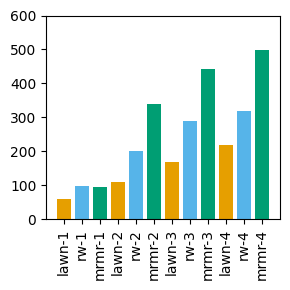

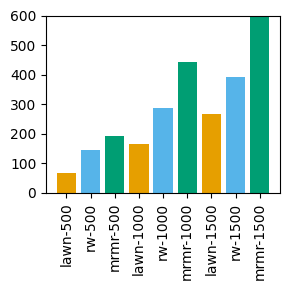

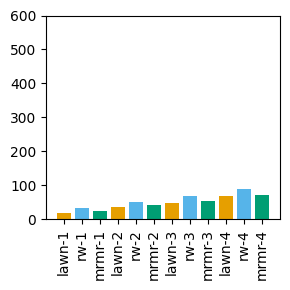

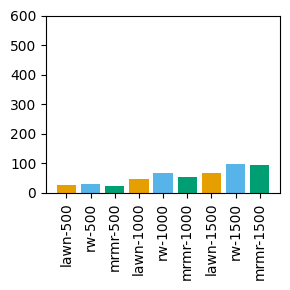

In [11]:
b1000_clustered_lookup = {
"gen-lawn-n_1-b_1000-e_mrmr-custom-clustered": "lawn-1",
"gen-rw-n_1-b_1000-e_mrmr-custom-clustered": "rw-1",
"gen-mrmr-n_1-b_1000-e_mrmr-custom-clustered": "mrmr-1",
"gen-lawn-n_2-b_1000-e_mrmr-custom-clustered": "lawn-2",
"gen-rw-n_2-b_1000-e_mrmr-custom-clustered": "rw-2",
"gen-mrmr-n_2-b_1000-e_mrmr-custom-clustered": "mrmr-2",
"gen-lawn-n_3-b_1000-e_mrmr-custom-clustered": "lawn-3",
"gen-rw-n_3-b_1000-e_mrmr-custom-clustered": "rw-3",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-clustered": "mrmr-3",
"gen-lawn-n_4-b_1000-e_mrmr-custom-clustered": "lawn-4",
"gen-rw-n_4-b_1000-e_mrmr-custom-clustered": "rw-4",
"gen-mrmr-n_4-b_1000-e_mrmr-custom-clustered": "mrmr-4"
}

b1000_unclustered_lookup = {
"gen-lawn-n_1-b_1000-e_mrmr-custom-notclustered": "lawn-1",
"gen-rw-n_1-b_1000-e_mrmr-custom-notclustered": "rw-1",
"gen-mrmr-n_1-b_1000-e_mrmr-custom-notclustered": "mrmr-1",
"gen-lawn-n_2-b_1000-e_mrmr-custom-notclustered": "lawn-2",
"gen-rw-n_2-b_1000-e_mrmr-custom-notclustered": "rw-2",
"gen-mrmr-n_2-b_1000-e_mrmr-custom-notclustered": "mrmr-2",
"gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered": "lawn-3",
"gen-rw-n_3-b_1000-e_mrmr-custom-notclustered": "rw-3",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-notclustered": "mrmr-3",
"gen-lawn-n_4-b_1000-e_mrmr-custom-notclustered": "lawn-4",
"gen-rw-n_4-b_1000-e_mrmr-custom-notclustered": "rw-4",
"gen-mrmr-n_4-b_1000-e_mrmr-custom-notclustered": "mrmr-4"
}

n3_clustered_lookup = {
"gen-lawn-n_3-b_500-e_mrmr-custom-clustered": "lawn-500",
"gen-rw-n_3-b_500-e_mrmr-custom-clustered": "rw-500",
"gen-mrmr-n_3-b_500-e_mrmr-custom-clustered": "mrmr-500",
"gen-lawn-n_3-b_1000-e_mrmr-custom-clustered": "lawn-1000",
"gen-rw-n_3-b_1000-e_mrmr-custom-clustered": "rw-1000",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-clustered": "mrmr-1000",
"gen-lawn-n_3-b_1500-e_mrmr-custom-clustered": "lawn-1500",
"gen-rw-n_3-b_1500-e_mrmr-custom-clustered": "rw-1500",
"gen-mrmr-n_3-b_1500-e_mrmr-custom-clustered": "mrmr-1500"
}

n3_unclustered_lookup = {
"gen-lawn-n_3-b_500-e_mrmr-custom-notclustered": "lawn-500",
"gen-rw-n_3-b_500-e_mrmr-custom-notclustered": "rw-500",
"gen-mrmr-n_3-b_500-e_mrmr-custom-notclustered": "mrmr-500",
"gen-lawn-n_3-b_1000-e_mrmr-custom-notclustered": "lawn-1000",
"gen-rw-n_3-b_1000-e_mrmr-custom-notclustered": "rw-1000",
"gen-mrmr-n_3-b_1000-e_mrmr-custom-notclustered": "mrmr-1000",
"gen-lawn-n_3-b_1500-e_mrmr-custom-notclustered": "lawn-1500",
"gen-rw-n_3-b_1500-e_mrmr-custom-notclustered": "rw-1500",
"gen-mrmr-n_3-b_1500-e_mrmr-custom-notclustered": "mrmr-1500"
}

comparative_detections(runs_b1000_clustered, "by_robot_count_clustered", ROBOT_COLORS[0:3], b1000_clustered_lookup)
comparative_detections(runs_n3_clustered, "by_budget_clustered", ROBOT_COLORS[0:3], n3_clustered_lookup)
comparative_detections(runs_b1000_unclustered, "by_robot_count_unclustered", ROBOT_COLORS[0:3], b1000_unclustered_lookup)
comparative_detections(runs_n3_unclustered, "by_budget_unclustered", ROBOT_COLORS[0:3], n3_unclustered_lookup)

